# Final Results from the Social Media Question Experiment
J. Nathan Matias (April 2, 2019)

In this document, I conduct the across-experiment analysis of the social media question experiment, as defined in the pre-analysis plan. The pre-analysis plan at: https://osf.io/fe3vj/

This post illustrates several concepts:
* using a random intercepts model to estimate the average treatment effect across multiple experiments
* using randomization inference to analyze multiple experiments together
* imputing data to estimate extreme bounds on the average treatment effect


#### About This Data
The data used in this study was collected by students in the [SOC412](https://natematias.com/courses/soc412/) class on field experiments at Princeton University in the spring of 2019. The full experiment procedure is described in the pre-analysis plan, as well as the [Social Media Question Experiment](https://github.com/natematias/SOC412/tree/master/2-facebook-qa) description on github.

Note: The 18th day out of 22 was omitted from most experiments through a big in the randomization spreadsheet. While the randomization is still valid for the 21 days that were included, I have taken this as an opportunity to illustrate different ways of handling missing data. For an analysis that estimates the complier average treatment effect, [see this notebook](https://github.com/natematias/SOC412/blob/master/3-social-media-question/Analyzing%20the%20Question%20Experiment.ipynb).

I have inserted an empty row with NA values, along with information about what assignment the row would have received in the case of a balanced randomization scheme. I have also added the "compliance" column (1/0) to indicate whether the procedure was completed on that day.

In this example, I show how to use imputed data to estimate the average treatment effect under conditions where we impute the mean as well as estimate the upper and lower bounds. I report the final result based on imputing the mean.

For more about handling missing data (attrition) from an experiment, see the chapter on attrition in:
* Gerber, A. S., & Green, D. P. (2008). Field experiments and natural experiments. In The Oxford handbook of political science.

In [1]:
library(ggplot2)
library(MASS)
library(ri2)
library(lme4)
library(lmerTest)
library(gmodels)
library(viridis)
library(estimatr)
options(repr.plot.width=7, repr.plot.height=3.5)
sessionInfo()
cbbPalette <- c("#333333", "#009E73", "#e79f00", "#9ad0f3", "#0072B2", "#D55E00", 
    "#CC79A7", "#F0E442")

Loading required package: randomizr
Loading required package: estimatr
Loading required package: Matrix

Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step

Loading required package: viridisLite


R version 3.5.1 (2018-07-02)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.14.3

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] viridis_0.5.1     viridisLite_0.3.0 gmodels_2.18.1    lmerTest_3.0-1   
 [5] lme4_1.1-19       Matrix_1.2-15     ri2_0.1.2         estimatr_0.14    
 [9] randomizr_0.16.1  MASS_7.3-51.1     ggplot2_3.1.0    

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.0        nloptr_1.2.1      pillar_1.3.1      compiler_3.5.1   
 [5] plyr_1.8.4        bindr_0.1.1       base64enc_0.1-3   tools_3.5.1      
 [9] digest_0.6.18     uuid_0.1-2        nlme_3.1-137      lattice_0.20-38  
[13] jsonlite_1.

In [2]:
discussions <- read.csv("question-experiment-03.26.2019.all.students.csv", na.strings=c("NA","N/A", " "))
colnames(discussions)

[1] "compliance"                      "post.id"                        
 [3] "condition"                       "day"                            
 [5] "characters"                      "likes"                          
 [7] "comments"                        "shares"                         
 [9] "interactions"                    "popularity.prediction"          
[11] "platform"                        "friends.at.beginning.obfuscated"
[13] "experimenter"                    "topics"

## Summary Statistics
* **compliance**: 1 if the experimenter completed the procedure, 0 if the experimenter didn't
* **post.id**: in sequence, what post was this?
* **condition**: was this a treatment or control intervention? Treatment involved inviting comments from participants
* **day**: supposed to be the date, but varies
* **text**: for some experimenters, the text of the post
* **characters**: for some experimenters, how long the text was
* **likes**: number of likes received in 24 hours
* **comments**: number of comments received in 24 hours
* **shares**: number of shares received in 24 hours
* **interactions**: should be a sum of likes, comments, shares
* **popularity.prediction**: from 1 to 5, how popular did the poster think it would be
* **platform**: platform where the experiment occurred
* **friends.at.beginning**: number of friends the experimenter had at the beginning of the study, with +/- 10 fuzz added
* **experimenter**: experimenter code
* **topics**: topic annotation from experimenter

# Review per-experimenter distributions

In [3]:
print("Experiment Compliance (out of 1)")
print(aggregate(discussions$compliance,
    FUN=mean, by = list(discussions$experimenter)))

[1] "Experiment Compliance (out of 1)"
   Group.1         x
1       X1 0.8181818
2       X2 0.8636364
3       X3 0.9545455
4       X4 0.9545455
5       X5 0.9545455
6       Y1 0.9545455
7       Y2 0.9545455
8       Y3 0.8181818
9       Y4 0.8181818
10      Z1 0.9545455
11      Z2 0.9545455
12      Z3 1.0000000
13      Z4 0.9545455
14      Z5 0.9545455


[1] "Interactions (removing NA values)"
   Group.1          x
1       X1  1.1111111
2       X2  0.6842105
3       X3  6.0476190
4       X4 10.1428571
5       X5 30.9047619
6       Y1  1.4761905
7       Y2 13.0000000
8       Y3 27.4285714
9       Y4  1.4285714
10      Z1 14.0000000
11      Z2 14.6666667
12      Z3 12.5454545
13      Z4 37.3809524
14      Z5 27.7142857


Warning message:
“Removed 18 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 18 rows containing missing values (geom_point).”

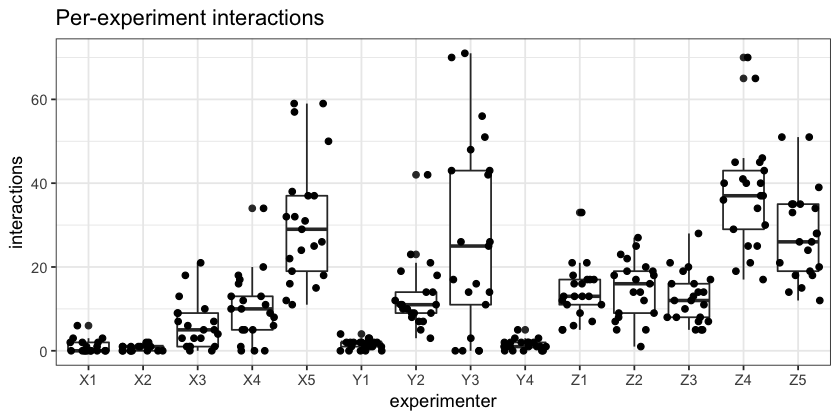

In [4]:
print("Interactions (removing NA values)")
print(aggregate(discussions$interactions,
    FUN=mean, by = list(discussions$experimenter), na.rm=TRUE))

ggplot(discussions, aes(experimenter, interactions)) +
    geom_boxplot() +
    geom_jitter(height=0) +
    theme_bw() +
    ggtitle("Per-experiment interactions")

[1] "Comments (removing NA values)"
   Group.1          x
1       X1 0.27777778
2       X2 0.05263158
3       X3 1.05000000
4       X4 0.94444444
5       X5 1.85714286
6       Y1 1.23809524
7       Y2 1.33333333
8       Y3 2.64705882
9       Y4 0.55555556
10      Z1 1.28571429
11      Z2 1.66666667
12      Z3 0.13636364
13      Z4 2.00000000
14      Z5 2.47619048


Warning message:
“Removed 29 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 29 rows containing missing values (geom_point).”

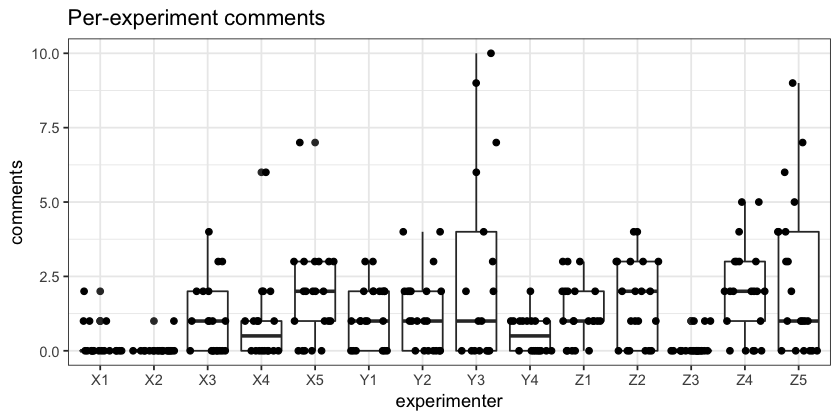

In [5]:
print("Comments (removing NA values)")
print(aggregate(discussions$comments,
    FUN=mean, by = list(discussions$experimenter), na.rm=TRUE))

ggplot(discussions, aes(experimenter, comments)) +
    geom_boxplot() +
    geom_jitter(height=0) +
    theme_bw() +
    ggtitle("Per-experiment comments")

In [6]:
summary(discussions$platform)

Facebook Instagram Stories           Twitter 
              242                44                22

In [7]:
summary(discussions$experimenter)

X1 X2 X3 X4 X5 Y1 Y2 Y3 Y4 Z1 Z2 Z3 Z4 Z5 
22 22 22 22 22 22 22 22 22 22 22 22 22 22

In [8]:
print("Overall condition balance")
summary(discussions$condition)
print("Overall condition balance among compliers")
summary(subset(discussions, compliance==1)$condition)

[1] "Overall condition balance"


control treatment 
      154       154

[1] "Overall condition balance among compliers"


control treatment 
      136       148

### Per Student Experiments

Warning message:
“Removed 29 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 29 rows containing missing values (geom_point).”

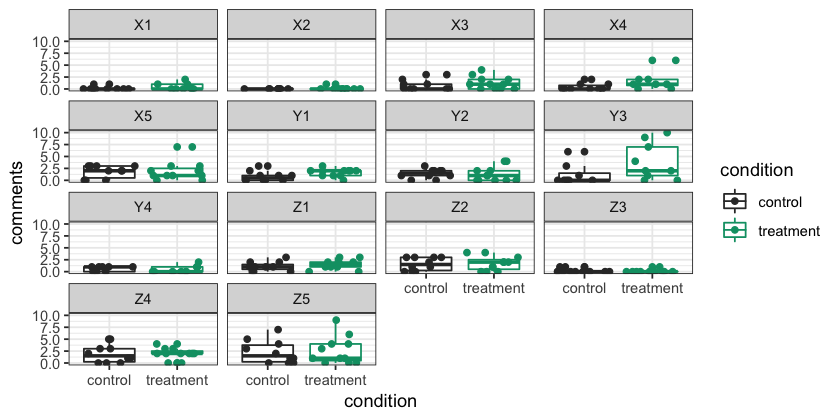

In [9]:
ggplot(discussions, aes(condition, comments, color=condition)) +
    geom_boxplot() +
    geom_jitter(height=0) +
    theme_bw() + 
    scale_color_manual(values=cbbPalette) +
    facet_wrap(. ~ experimenter )

Warning message:
“Removed 18 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 18 rows containing missing values (geom_point).”

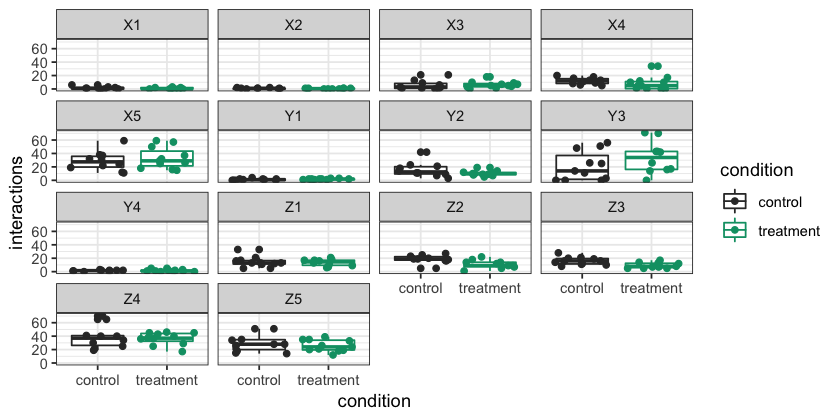

In [10]:
ggplot(discussions, aes(condition, interactions, color=condition)) +
    geom_boxplot() +
    geom_jitter(height=0) +
    theme_bw() + 
    scale_color_manual(values=cbbPalette) +
    facet_wrap(. ~ experimenter )

# Generate Results with Imputation

### Impute Values to Missing Observations
In this case, we impute the mean of the control group or the mean of the treatment group to the missing observations. We alsos estimate upper and lower bounds. Imagine if the missing observations had the lowest or the highest values from the control or treatment group- what would the effect be in those cases, if any?

In [11]:
discussions$comments.mean <- discussions$comments
discussions$comments.upr <- discussions$comments
discussions$comments.lwr <- discussions$comments

for(ex in unique(discussions$experimenter)){
    mean.treat <- round(mean(subset(discussions, experimenter == ex & condition=="treatment")$comments, na.rm=TRUE))
    max.treat <- max(subset(discussions, experimenter == ex & condition=="treatment")$comments, na.rm=TRUE)
    min.treat <- min(subset(discussions, experimenter == ex & condition=="treatment")$comments, na.rm=TRUE)

    mean.ctl <- round(mean(subset(discussions, experimenter == ex & condition=="control")$comments, na.rm=TRUE))
    max.ctl  <- max(subset(discussions, experimenter == ex & condition=="control")$comments, na.rm=TRUE)
    min.ctl  <- min(subset(discussions, experimenter == ex & condition=="control")$comments, na.rm=TRUE)
        
    if(nrow(subset(discussions, experimenter == ex & condition == "control" & is.na(comments)))>0){

        # for mean, we impute the mean
        discussions[is.na(discussions$comments.mean) & 
                    discussions$condition=="control" & 
                    discussions$experimenter == ex,]$comments.mean <- mean.ctl
        
        ## for experiment upper bounds
        ## we give the control group the min values 
        ## we give the treatment group the max values
        discussions[is.na(discussions$comments.upr) & 
                    discussions$condition=="control" & 
                    discussions$experimenter == ex,]$comments.upr <- min.ctl

        ## for experiment lower bounds
        ## we give the control group the min values 
        ## we give the treatment group the max values
        discussions[is.na(discussions$comments.lwr) & 
                    discussions$condition=="control" & 
                    discussions$experimenter == ex,]$comments.lwr <- max.ctl
    
    }
    if(nrow(subset(discussions, experimenter == ex & condition == "treatment" & is.na(comments)))>0){
        # for mean, we impute the mean
        discussions[is.na(discussions$comments.mean) & 
                    discussions$condition=="treatment" & 
                    discussions$experimenter == ex,]$comments.mean <- mean.treat

        ## for experiment upper bounds
        ## we give the control group the min values 
        ## we give the treatment group the max values
        discussions[is.na(discussions$comments.upr) & 
                    discussions$condition=="treatment" & 
                    discussions$experimenter == ex,]$comments.upr <- max.treat

        ## for experiment lower bounds
        ## we give the control group the max values 
        ## we give the treatment group the min values
        discussions[is.na(discussions$comments.lwr) & 
                    discussions$condition=="treatment" & 
                    discussions$experimenter == ex,]$comments.lwr <- min.treat
    
    }
    
}

## Randomization Inference

### First: Imputing Based on Meanss

In [12]:
declaration <- with(discussions,
                   {
                       declare_ra(blocks=discussions$experimenter)
                   })
print(declaration)
print("")
discussions$Z <- as.numeric(discussions$condition == "treatment")
discussions$Y <- discussions$comments.mean

all.comments.ri <- conduct_ri(
    formula = Y ~ Z,
    declaration = declaration,
    sharp_hypothesis = 0,
    data = discussions
)
summary(all.comments.ri)

Random assignment procedure: Block random assignment 
Number of units: 308 
Number of blocks: 14
Number of treatment arms: 2 
The possible treatment categories are 0 and 1.
The number of possible random assignments is 7.55739616848645e+81.  
The probabilities of assignment are constant across units: 
prob_0 prob_1 
   0.5    0.5 
[1] ""


term,estimate,two_tailed_p_value
Z,0.4480519,0.006


### Randomization Inference Lower Bound

In [13]:
discussions$Y <- discussions$comments.lwr

all.comments.ri.lwr <- conduct_ri(
    formula = Y ~ Z,
    declaration = declaration,
    sharp_hypothesis = 0,
    data = discussions
)
summary(all.comments.ri.lwr)

term,estimate,two_tailed_p_value
Z,0.1038961,0.589


### Randomization Inference Upper Bound

In [14]:
discussions$Y <- discussions$comments.upr

all.comments.ri.upr <- conduct_ri(
    formula = Y ~ Z,
    declaration = declaration,
    sharp_hypothesis = 0,
    data = discussions
)
summary(all.comments.ri.upr)

term,estimate,two_tailed_p_value
Z,0.7727273,0


## Random Intercepts Negative Binomial Estimator
### First imputing mean values

In [15]:
nb1.imputed <- summary(glmer.nb(comments.mean ~ condition + (1|experimenter), data=discussions))
nb1.imputed

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: Negative Binomial(2.8521)  ( log )
Formula: comments.mean ~ condition + (1 | experimenter)
   Data: discussions

     AIC      BIC   logLik deviance df.resid 
   887.2    902.2   -439.6    879.2      304 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.1892 -0.6854 -0.3406  0.5065  3.6899 

Random effects:
 Groups       Name        Variance Std.Dev.
 experimenter (Intercept) 0.8583   0.9264  
Number of obs: 308, groups:  experimenter, 14

Fixed effects:
                   Estimate Std. Error z value Pr(>|z|)   
(Intercept)         -0.2854     0.2724  -1.048  0.29482   
conditiontreatment   0.3594     0.1288   2.792  0.00524 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
cndtntrtmnt -0.267

In [16]:
nb1.imputed.result <- data.frame(
    estimate <- nb1.imputed$coefficients['conditiontreatment',][['Estimate']],
    estimate.label <- paste(
        sprintf("%0.0f", (exp(nb1.imputed$coefficients['conditiontreatment',][['Estimate']])-1)*100), "%", sep=""),
    condition = "QUESTION",
    conf.upr <- nb1.imputed$coefficients['conditiontreatment',][['Estimate']] +
                1.96*nb1.imputed$coefficients['conditiontreatment',][['Std. Error']],
    conf.lwr <- nb1.imputed$coefficients['conditiontreatment',][['Estimate']] -
                1.96*nb1.imputed$coefficients['conditiontreatment',][['Std. Error']],
    p.value <- nb1.imputed$coefficients['conditiontreatment',][['Pr(>|z|)']],
    n = nrow(discussions)
)

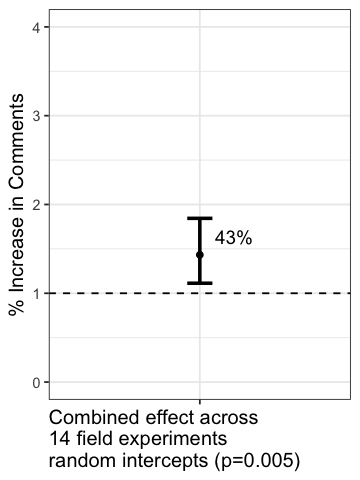

In [17]:
options(repr.plot.width=3, repr.plot.height=4)

ggplot(nb1.imputed.result, aes(condition, exp(estimate), label=estimate.label)) +
    geom_point()  +
    geom_errorbar(aes(ymin=exp(conf.lwr), ymax=exp(conf.upr)), width=0.1, size=1) +
    geom_hline(yintercept=1,  linetype="dashed") +
    geom_text(hjust=-0.40, vjust=-0.8, size=4) +
    ylim(0,4) +
    ylab("% Increase in Comments") +
    xlab(paste("Combined effect across\n",
               length(unique(discussions$experimenter)), 
               " field experiments\n",
               "random intercepts (p=",
               sprintf("%0.03f", nb1.imputed.result$p.value),")",sep="")) +
    theme_bw() +
    theme(axis.text.x=element_blank(),
          axis.title.x = element_text(size=12, hjust=0),
          axis.title.y = element_text(size=12))

options(repr.plot.width=7, repr.plot.height=3.5)

### Average Treatment Effect Imputing Lower Bound

In [18]:
summary(glmer.nb(comments.lwr ~ condition + (1|experimenter), data=discussions))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: Negative Binomial(2.0767)  ( log )
Formula: comments.lwr ~ condition + (1 | experimenter)
   Data: discussions

     AIC      BIC   logLik deviance df.resid 
   920.3    935.2   -456.2    912.3      304 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0958 -0.7032 -0.3419  0.4765  4.4707 

Random effects:
 Groups       Name        Variance Std.Dev.
 experimenter (Intercept) 0.8534   0.9238  
Number of obs: 308, groups:  experimenter, 14

Fixed effects:
                   Estimate Std. Error z value Pr(>|z|)
(Intercept)        -0.08585    0.27077  -0.317    0.751
conditiontreatment  0.08561    0.13317   0.643    0.520

Correlation of Fixed Effects:
            (Intr)
cndtntrtmnt -0.253

### Average Treatment Effect Imputing Upper Bound

In [19]:
summary(glmer.nb(comments.upr ~ condition + (1|experimenter), data=discussions))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: Negative Binomial(1.6674)  ( log )
Formula: comments.upr ~ condition + (1 | experimenter)
   Data: discussions

     AIC      BIC   logLik deviance df.resid 
   913.8    928.7   -452.9    905.8      304 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0536 -0.7014 -0.3669  0.4474  2.9971 

Random effects:
 Groups       Name        Variance Std.Dev.
 experimenter (Intercept) 0.6814   0.8255  
Number of obs: 308, groups:  experimenter, 14

Fixed effects:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -0.3566     0.2516  -1.417    0.156    
conditiontreatment   0.6044     0.1440   4.196 2.72e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
cndtntrtmnt -0.339

### Plotting All Individual Experiments Using Imputed Means (linear estimator)

In [20]:
full.results.log1p <- data.frame(
    experimenter = NA,
    friends.at.beginning = NA,
    platform = NA,
    observations = NA,
    intercept.coef = NA,
    intercept.stderr = NA,
    treat.coef = NA,
    treat.stderr = NA,
    treat.coef.upr = NA,
    treat.coef.lwr = NA,
    treat.pvalue = NA
)

full.results.mean <- cbind(full.results.log1p)

for(ex in unique(discussions$experimenter)){
    ex.df <- subset(discussions, experimenter==ex)
    cat(paste(ex,""))
        
    estimator.log1p <- summary(lm1 <- lm(log1p(comments.mean) ~ condition, 
                            data = ex.df))
    
    treat.coef.log1p <- estimator.log1p$coefficients['conditiontreatment',][['Estimate']]
    treat.stderr.log1p <- estimator.log1p$coefficients['conditiontreatment',][['Std. Error']]
    
    out.df <- data.frame(
        experimenter = ex.df$experimenter[1],
        friends.at.beginning = ex.df$friends.at.beginning[1],
        platform = ex.df$platform[1],
        observations = nrow(subset(ex.df, compliance ==1)),
        intercept.coef = estimator.log1p$coefficients['(Intercept)',][['Estimate']],
        intercept.stderr = estimator.log1p$coefficients['(Intercept)',][['Std. Error']],
        treat.coef = treat.coef.log1p,
        treat.coef.upr = treat.coef.log1p + 1.96 * treat.stderr.log1p,
        treat.coef.lwr = treat.coef.log1p - 1.96 * treat.stderr.log1p,
        treat.stderr = treat.stderr.log1p,
        treat.pvalue = estimator.log1p$coefficients['conditiontreatment',][['Pr(>|t|)']]    
    )
    full.results.log1p <- rbind(full.results.log1p, out.df)
    
    estimator.mean <- summary(lm2 <- lm(comments ~ condition, 
                              data = ex.df))
    
    treat.coef.mean <- estimator.mean$coefficients['conditiontreatment',][['Estimate']]
    treat.stderr.mean <- estimator.mean$coefficients['conditiontreatment',][['Std. Error']]
    
    out.df.mean <- data.frame(
        experimenter = ex.df$experimenter[1],
        friends.at.beginning = ex.df$friends.at.beginning[1],
        platform = ex.df$platform[1],
        observations = nrow(subset(ex.df, compliance ==1)),
        intercept.coef = estimator.mean$coefficients['(Intercept)',][['Estimate']],
        intercept.stderr = estimator.mean$coefficients['(Intercept)',][['Std. Error']],
        treat.coef = treat.coef.mean,
        treat.coef.upr = treat.coef.mean + 1.96 * treat.stderr.mean,
        treat.coef.lwr = treat.coef.mean - 1.96 * treat.stderr.mean,
        treat.stderr = treat.stderr.mean,
        treat.pvalue = estimator.mean$coefficients['conditiontreatment',][['Pr(>|t|)']]    
    )
    full.results.mean <- rbind(full.results.mean, out.df.mean)
    
}
full.results.log1p <- subset(full.results.log1p, is.na(experimenter)!=TRUE)
full.results.mean <- subset(full.results.mean, is.na(experimenter)!=TRUE)

Z1 Y1 X1 X2 Y2 Z2 Z3 X3 Y3 Z4 Y4 X4 Z5 X5 

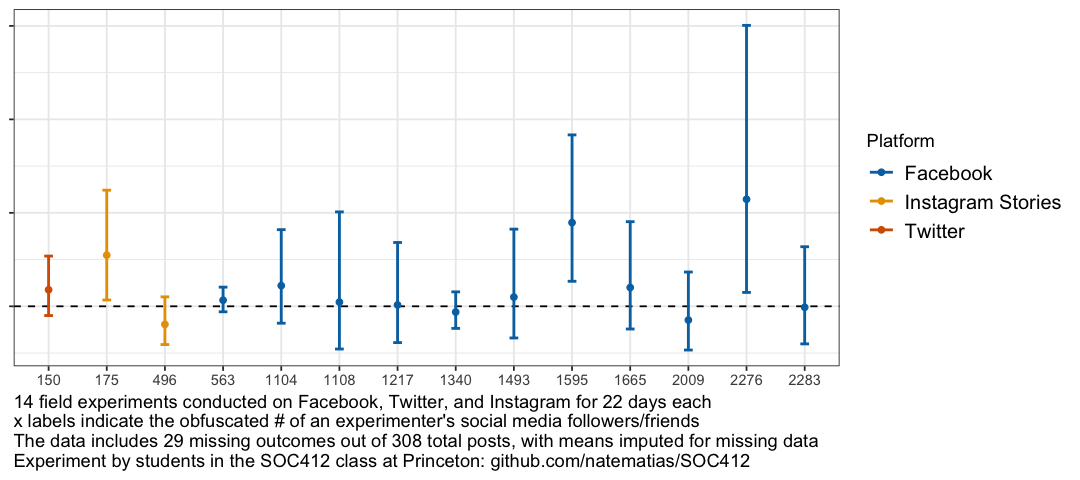

In [38]:
options(repr.plot.width=9, repr.plot.height=4)

ggplot(full.results.log1p, aes(factor(friends.at.beginning), exp(treat.coef), color=platform)) +
    geom_hline(yintercept=1,  linetype="dashed") +
    geom_point() +
    labs(color="Platform") +
    geom_errorbar(aes(ymin = exp(treat.coef.lwr), ymax = exp(treat.coef.upr)),  width=0.15, size=0.8) +
    theme_bw() +
    scale_color_manual(values=c(cbbPalette[5], cbbPalette[3], cbbPalette[6])) +
    theme(
          axis.text.y=element_blank(),
          axis.title.x = element_text(size=11, hjust=0),
          axis.title.y = element_blank(),
          legend.text=element_text(size=12)) +
    xlab(paste(length(unique(discussions$experimenter)), 
               " field experiments conducted on Facebook, Twitter, and Instagram for 22 days each\n",
               "x labels indicate the obfuscated # of an experimenter's social media followers/friends\n",
               "The data includes ", nrow(subset(discussions, is.na(comments))), " missing outcomes out of ",
               nrow(discussions), " total posts, with means imputed for missing data\n", 
               "Experiment by students in the SOC412 class at Princeton: github.com/natematias/SOC412",sep=""))


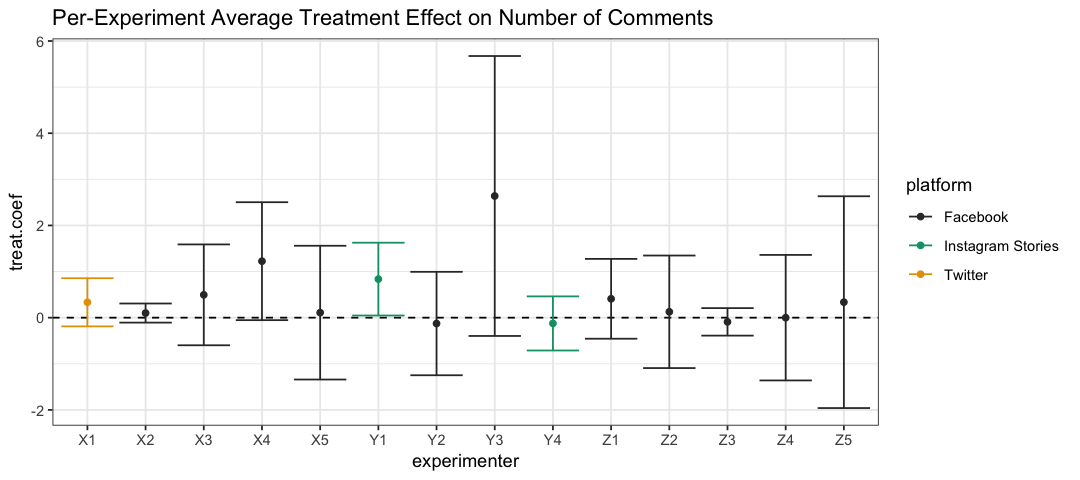

In [22]:
ggplot(full.results.mean, aes(experimenter, treat.coef, color=platform)) +
    geom_hline(yintercept=0,  linetype="dashed") +
    geom_point() +
    geom_errorbar(aes(ymin = treat.coef.lwr, ymax = treat.coef.upr)) +
    theme_bw() +
    scale_color_manual(values=cbbPalette) +
    ggtitle("Per-Experiment Average Treatment Effect on Number of Comments")

# How Good Were Experimenters at Predicting Discussion Popularity?

In [23]:
p1 <- summary(lm(interactions ~ popularity.prediction, subset(discussions, is.na(popularity.prediction)!=TRUE & is.na(interactions)!=TRUE)))
p1.cor <- sprintf("%0.2f", p1$coefficients['popularity.prediction',][['Estimate']])
p1.p <- sprintf("%0.2f", p1$coefficients['popularity.prediction',][['Pr(>|t|)']])
p1.r2 <- sprintf("%0.2f", p1$r.squared)

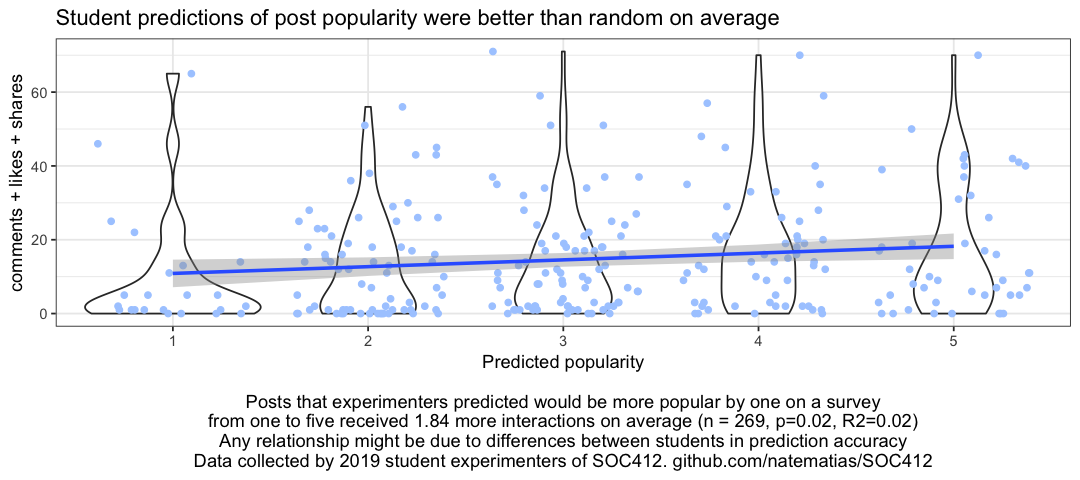

In [24]:
ggplot(subset(discussions, is.na(popularity.prediction)!=TRUE & is.na(interactions)!=TRUE), aes(popularity.prediction, interactions)) +
    geom_violin(aes(factor(popularity.prediction), interactions)) +
    geom_jitter(height=0, color="#aaccff") +
    geom_smooth(formula = y ~ x, method=lm) +
    theme_bw() +
    ggtitle("Student predictions of post popularity were better than random on average")  +
    ylab("comments + likes + shares") +
    xlab(paste("Predicted popularity\n\n","Posts that experimenters predicted would be more popular by one on a survey\n",
                  "from one to five received ", p1.cor, " more interactions on average (n = ", 
                  nrow(subset(discussions, is.na(popularity.prediction)!=TRUE & is.na(interactions)!=TRUE)),", p=",
                  p1.p , ", R2=", p1.r2 ,")", "\n", 
                  "Any relationship might be due to differences between students in prediction accuracy\n",
                  "Data collected by 2019 student experimenters of SOC412. github.com/natematias/SOC412",
                  sep=""))
